In [1]:
# Boilerplate
%matplotlib inline

# Intel DAAL related imports
from daal.data_management import HomogenNumericTable

# Helpersfor getArrayFromNT and printNT. See utils.py
from utils import *

# Import numpy, matplotlib, seaborn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Plotting configurations
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 9)

# Linear Regression 

### Tutorial brief
This tutorial is an example of using linear regression algorithms from pyDAAL to build predictive models. We use the well-studied Boston House Prices dataset to train a basic multiple linear regression model, and then a Ridge regression model. We  test the performance of these models in median house price prediction. The code for multiple linear regression model training and prediction is provided. You are required to write the code for Ridge regression model training and prediction.

### Learning objectives
* To understand and practice the typical code sequence of using pyDAAL for supervised learning.
* To practice interactions and conversions between DAAL NumericTables and NumPy ndarrays.

### Linear regression introduction
Supervised learning involves training a model using data that has known responses, and then apply the model to predict responses for unseen data. In the case of **linear regression**, the model is linear. That is, 

$$ f_{\beta}(X) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k $$

$\beta_0, \beta_1, \cdots, \beta_k$ are the regression model coefficients. 

pyDAAL provides two linear regression algorithms:
* **Multiple Linear Regression**: The model is trained by minimizing an objective function in the form of **Residual Sum of Squares**. pyDAAL supports two ways to train the model: 1) Normal Equation method, and 2) QR method.

$$ \sum \limits_{i=1}^n\left ( y_i - f_{\beta}(X^i)\right )^2 $$  
* **Ridge Regression**: It is similar to multiple linear regression, but adds a regularization term to the objective function. The regularization term penalizes features with large values, thus makes the model less prone to overfitting. 

$$ \sum \limits_{i=1}^n\left ( y_i - f_{\beta}(X^i)\right )^2 + \alpha \sum \limits_{j=1}^k \beta_j^2 $$


### The Boston House Prices dataset
The dataset has already been downloaded to the ./mldata folder. There are 506 rows and 14 columns. The first 13 columns are features (explanatory variables), and the last column is the dependent variable we try to make predictions for. Here's detailed information about this dataset, including descriptions of each feature:

> Origin: 

> This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. 

> Creator: 

> Harrison, D. and Rubinfeld, D.L. 
> 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

> Data Set Information:

> Concerns housing values in suburbs of Boston.


> Attribute Information:

> 1. CRIM: per capita crime rate by town 
> 2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
> 3. INDUS: proportion of non-retail business acres per town 
> 4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
> 5. NOX: nitric oxides concentration (parts per 10 million) 
> 6. RM: average number of rooms per dwelling 
> 7. AGE: proportion of owner-occupied units built prior to 1940 
> 8. DIS: weighted distances to five Boston employment centres 
> 9. RAD: index of accessibility to radial highways 
> 10. TAX: full-value property-tax rate per \$10,000 
> 11. PTRATIO: pupil-teacher ratio by town 
> 12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
> 13. LSTAT: % lower status of the population 
> 14. MEDV: Median value of owner-occupied homes in \$1000's



### Feature selection
To fit a good linear model, we usually need to carefully decide which features to be included as explanatory variables. Features that are not statistically significant should be excluded. Features that are highly correlated among themselves should also be excluded. Feature selection is an important topic by itself. But it is beyond the scope of this tutorial. For our purposes, let's just say we exclude `indus`, `age`, `zn`, `tax`, and `rad`. This leaves `crim`, `chas`, `nox`, `rm`, `dis`, `ptratio`, `b`, and `lstat` as the explanatory variables. These are corresponding to column indices 0, 3, 4, 5, 7, 10, 11, and 12 in the data. Later, when loading data into memory we'll choose only these columns.

### Multiple linear regression code using pyDAAL
The code below defines `class LinearRegression`, which encapsulates the basic multiple linear regression algorithm from pyDAAL. An instance of the class can be initialized using `normEq` or `qr`, corresponding to the two model training methods. Method `train` takes training data and the known response to learn a model and return it. Method `predict` takes a model object and test data, and make predictions. The code also defines function `getBetas` that returns the regression coefficients of a model; function `mse` that returns _mean squared errors_ (MSE) for given true values and fitted values; function `scores` that computes coefficient of determination _R-squared_.

In [2]:
from daal.algorithms.linear_regression import training as lr_training
from daal.algorithms.linear_regression import prediction as lr_prediction

def getBetas(linear_model):
    """Return regression coefficients for a given linear model

    Args:
        linear_model: A trained model

    Returns:
        A n-by-(k+1) NumericTable contains betas, where n is the number of dependent
        variables; k is the number of features (independent variables)
    """

    return linear_model.getBeta()




def mse(values, fitted_values):
    """Return Mean Squared Errors for fitted values w.r.t. true values

    Args:
        values: True values. NumericTable, nsamples-by-noutputs
        fitted_values: True values. NumericTable, nsamples-by-noutputs

    Returns:
        A tuple contains MSE's
    """

    y_t = getArrayFromNT(values)
    y_p = getArrayFromNT(fitted_values)
    rss = ((y_t - y_p) ** 2).sum(axis = 0)
    mse = rss / y_t.shape[0]
    return tuple(mse)




def score(y_true, y_pred):
    """Compute R-squared and adjusted R-squared

    Args:
        y_true: True values. NumericTable, shape = (nsamples, noutputs)
        y_pred: Predicted values. NumericTable, shape = (nsamples, noutputs)

    Returns:
        R2: A tuple with noutputs values
    """

    y_t = getArrayFromNT(y_true)
    y_p = getArrayFromNT(y_pred)
    rss = ((y_t - y_p) ** 2).sum(axis = 0)
    tss = ((y_t - y_t.mean(axis = 0)) ** 2).sum(axis = 0)
    r2 = 1 - rss/tss
    return tuple(r2)


class LinearRegression:


    def __init__(self, method = 'normEq'):
        """Initialize class parameters

        Args:
           method: The default method is based on Normal Equation ('normEq'). It
           can also be QR method ('qr')
        """

        if method != 'normEq' and method != 'qr':
            warnings.warn(method + 
            ' method is not supported. Default method is used', 
            UserWarning)

        self.method_ = method



    def train(self, data, responses):
        """Train a Linear Regression model.

        Args:
            data: Training data
            responses: Known responses to the training data

        Returns:
            A Linear Regression model object
        """

        # Create a training algorithm object
        if self.method_ == 'qr': 
            lr_training_alg = lr_training.Batch_Float64QrDense() 
        else:
            lr_training_alg = lr_training.Batch_Float64NormEqDense() 
        # Set input
        lr_training_alg.input.set(lr_training.data, data)
        lr_training_alg.input.set(lr_training.dependentVariables, responses)
        # Compute
        results = lr_training_alg.compute()
        # Return the trained model
        return results.get(lr_training.model)



    def predict(self, model, testdata, intercept = True):
        """Make prediction for unseen data using a trained model

        Args:
            model: A trained model
            testdata: New data
            intercept: A boolean to inidicate if intercept needs to be computed 

        Returns:
            A NumericTable containing predicted responses 
        """

        # Create a prediction algorithm object
        lr_prediction_alg = lr_prediction.Batch_Float64DefaultDense()
        # Set input
        lr_prediction_alg.input.setModel(lr_prediction.model, model)
        lr_prediction_alg.input.setTable(lr_prediction.data, testdata)
        # Set parameters
        lr_prediction_alg.parameter.interceptFlag = intercept
        # Compute
        results = lr_prediction_alg.compute()
        return results.get(lr_prediction.prediction)


### Linear regression model training and prediction for Boston houses prices
We save the last 50 samples from the entire dataset as test data, and use the rest as training data. The code below uses the `LinearRegression` class defined above. After training a model, we use it to predict prices for the last 50 samples. The code also shows computation of R-squared using the `scores` function, and retrieve the regression coefficients (betas) from the model.

The code below reads data from file `housing.data` and creates 4 NumericTables: training data (`boston_X_train`), training data ground truth (`boston_Y_train`), test data (`boston_X_test`), and test data ground truth (`boston_Y_test`). We use the `numpy.genfromtxt` function to read data from the file into ndarrays. Then, create NumericTables from the ndarrays. _Note that when creating NumericTables from ndarrays, it is critical the ndarrays must be C-contiguous in memory._ 

In [3]:
# Use only `crim`, `chas`, `nox`, `rm`, `dis`, `ptratio`, `b`, and `lstat` for explanatory variables
cols = (0,3,4,5,7,10,11,12)
data = np.genfromtxt('./mldata/housing.data', dtype=np.double, usecols=cols)
truth = np.genfromtxt('./mldata/housing.data', dtype=np.double, usecols=(13))

# Training data and responses
boston_X_train = HomogenNumericTable(data[:-50])
boston_Y_train = HomogenNumericTable(truth[:-50].reshape(-1,1))

# Test data and ground truth
boston_X_test = HomogenNumericTable(data[-50:])
boston_Y_test = HomogenNumericTable(truth[-50:].reshape(-1,1))

# Use the LinearRegression class for model training and prediction
regr = LinearRegression()
model = regr.train(boston_X_train, boston_Y_train)
predictions = regr.predict(model, boston_X_test)

# Calculate the coefficient of determination
R2 = score(boston_Y_test, predictions)
print(R2)

# Peek at the model (Betas)
printNT(getBetas(model))

(0.44116933893793719,)
 
 [[  2.87404604e+01  -5.00910527e-02   2.89388785e+00  -1.62558071e+01
    4.39060434e+00  -1.18956541e+00  -9.05072623e-01   8.96346755e-03
   -5.32682714e-01]]


### Plotting predicted values agains the ground truth
To see if the model has done a good job, we plot the predicted values against the ground truth. If the model does a perfect job then all points on the plot should fall on a straight line. As we see, it's not quite the case. But still the predictions are close to true values in many cases.

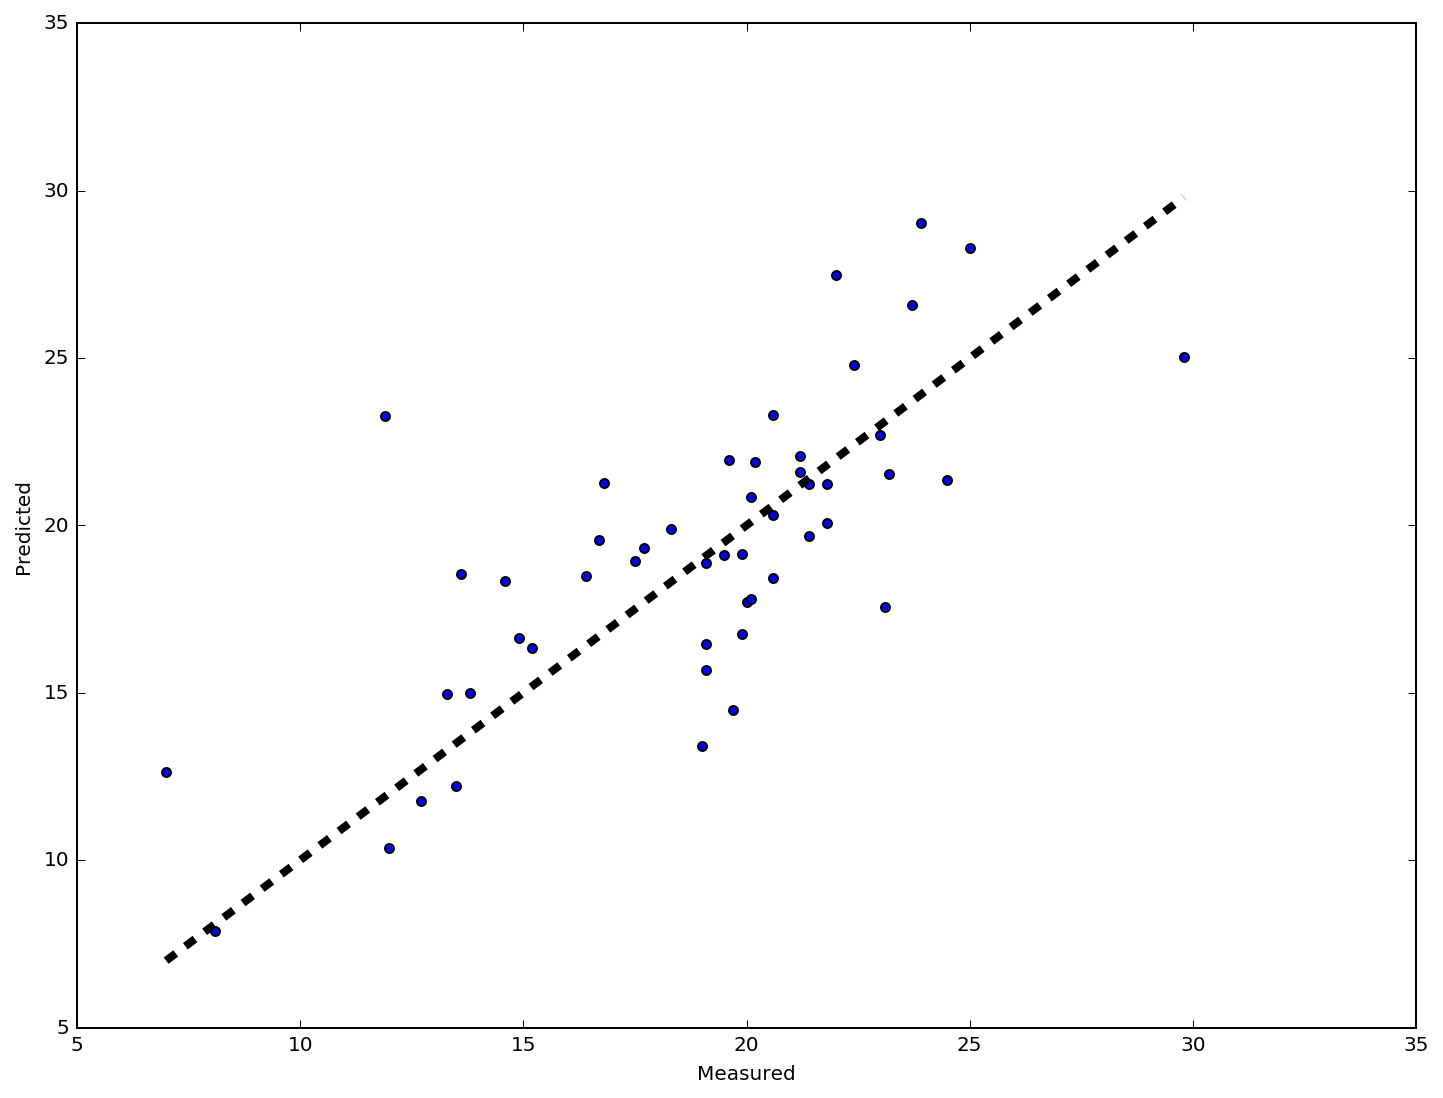

In [4]:
y = truth[-50:]
predicted = getArrayFromNT(predictions)

fig, ax = plt.subplots()
ax.scatter(y,predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Exercise: Implementing Ridge regression
In this exercise, you are asked to implement a class for Ridge regression using pyDAAL. Ridge regression is basically linear regression with regularizations. The skeleton of the Ridge class code is given below. It has two methods, **train** and **predict**. The implementation for **train** is already provided. You only need to follow it as a recipe to implement the **predict** method.

In [5]:
from daal.algorithms.ridge_regression import training as ridge_training
from daal.algorithms.ridge_regression import prediction as ridge_prediction

class Ridge:

    def __init__(self):
        pass



    def train(self, data, responses, alpha = 1.0):
        """Train a Ridge Regression model.

        Args:
           data: Training data
           responses: Known responses to the training data
           alpha: Regularization parameter, a small positive value with default
           1.0

        Returns:
            A Ridge Regression model object
        """

        # Create a training algorithm object
        ridge_training_alg = ridge_training.Batch_Float64DefaultDense() 
        # Set input
        ridge_training_alg.input.set(ridge_training.data, data)
        ridge_training_alg.input.set(ridge_training.dependentVariables, responses)
        # Set parameter
        alpha_nt = HomogenNumericTable(np.array([alpha], ndmin=2))
        ridge_training_alg.parameter.ridgeParameters = alpha_nt
        # Compute
        results = ridge_training_alg.compute()
        # Return the trained model
        return results.get(ridge_training.model)



    def predict(self, model, testdata, intercept = True):
        """Make prediction for unseen data using a trained model

        Args:
            model: A trained model
            testdata: New data
            intercept: A boolean to inidicate if intercept needs to be computed 

        Returns:
            A NumericTable containing predicted responses 
        """

        # Create a prediction algorithm object
        #
        # YOUR CODE HERE
        #
        # The algorithm class you want to use is ridge_prediction.Batch_Float64DefaultDense
        
        
        # Set input
        #
        # YOUR CODE HERE
        #
        # There are two pieces of input to be set: a pre-trained model and input data. You should
        # use the 'input.setModelInput' and the 'input.setNumericTableInput' member methods of the
        # algorithm object. The input IDs to use are 'ridge_prediction.model' and 'ridge_prediction.data'
        # respectively.
        
    
        # Set parameters
        #
        # YOUR CODE HERE
        #
        # There is only one parameter we need to set. 'parameter.interceptFlag', it is a member variable 
        # of the algorithm object. 

        
        # Compute
        #
        # YOUR CODE HERE
        #
        # Call the 'compute' method of your algorithm object, and store the result to 'results'.
        
        return results.get(ridge_prediction.prediction)

Test your Ridge regression class using the same Boston House Prices dataset. Note that all data read in previous steps is still available. You can try different values of $\alpha$ (regularization parameter) to see its effect.

[ 0.38482985]


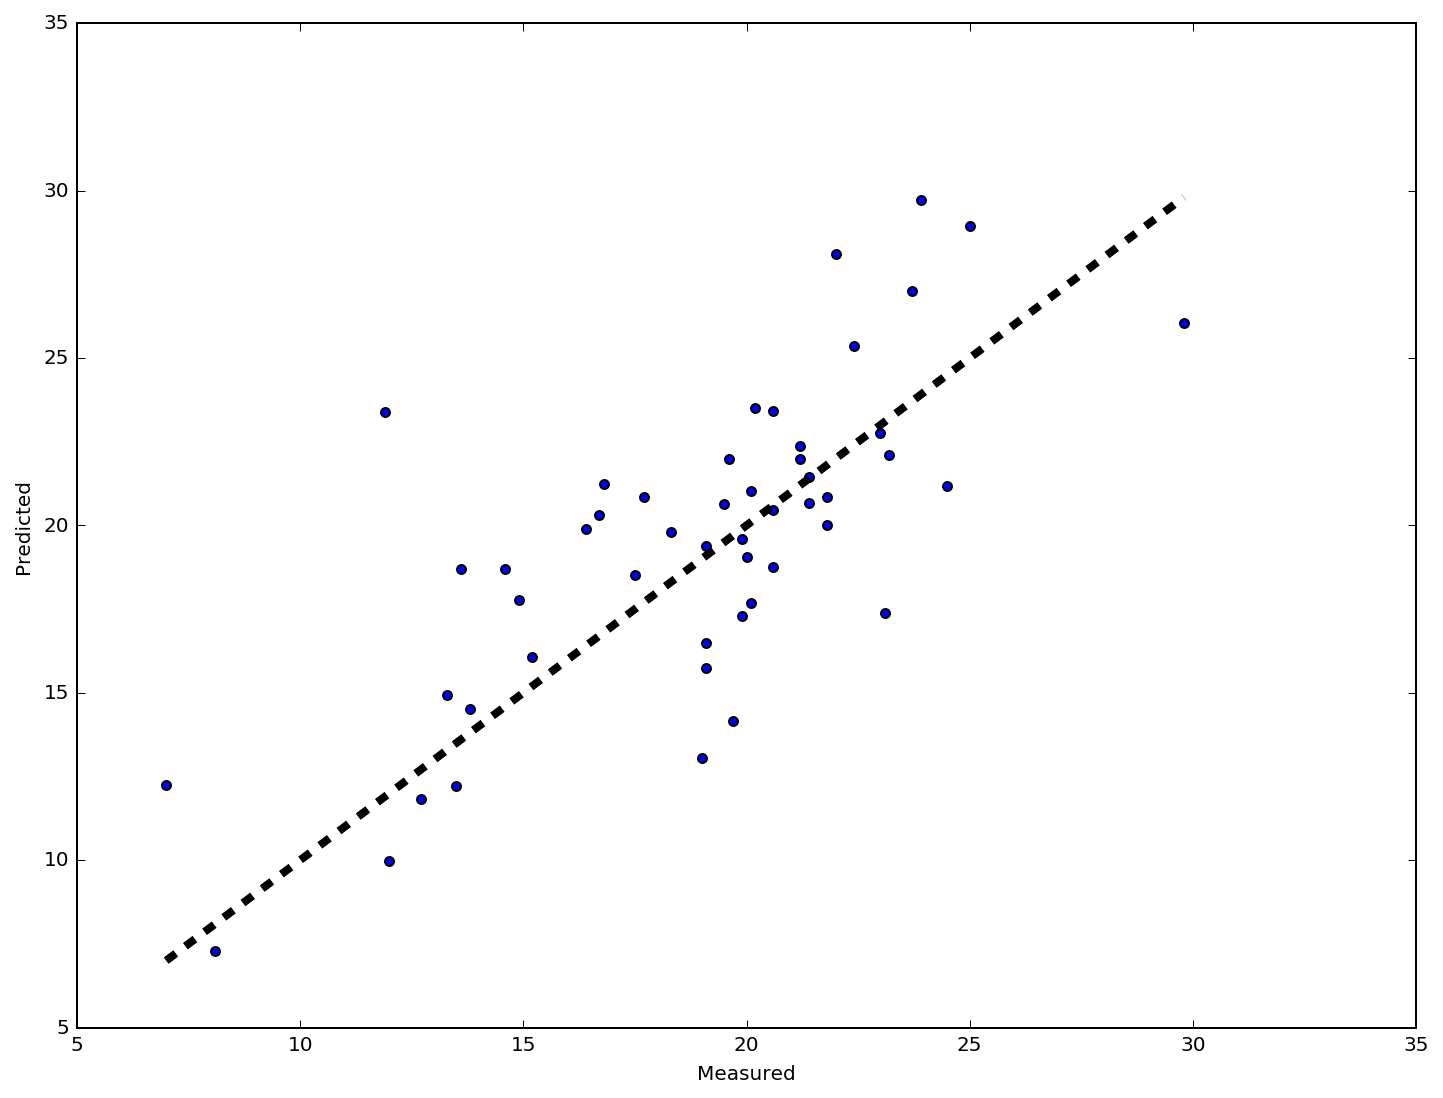

In [6]:
#from regression import *

# Use the Ridge class for model training and prediction
regr = Ridge()
model = regr.train(boston_X_train, boston_Y_train, alpha = 1.0)
predictions = regr.predict(model, boston_X_test)

# Calculate the coefficient of determination
R2 = score(boston_Y_test, predictions)
print(R2)

y = truth[-50:]
predicted = getArrayFromNT(predictions)

fig, ax = plt.subplots()
ax.scatter(y,predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Summary
In this lab, we learned two widely used linear regression models: Multiple linear regression and Ridge regression. We saw how to apply them to the Boston House Prices dataset. We studied and practiced pyDAAL API for these two algorithms.